<a href="https://colab.research.google.com/github/Omendra108/CV-Project-Group-14/blob/main/CV_Project_U_net_G14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementing the CS(Crack Segmentation) network based on the research paper using U-net architecture.

In [ ]:
# Install segmentation models PyTorch and kaggle API client
!pip install -q segmentation-models-pytorch
!pip install -q kaggle


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.0 MB/s eta 0:00:00


In [ ]:
# Upload your kaggle.json (Kaggle API token file)
from google.colab import files
files.upload()  # ← upload your `kaggle.json` here

# Move it to the appropriate config location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
# Download your crack segmentation dataset
# Replace the placeholder below with your actual dataset name from Kaggle
!kaggle datasets download -d omendrakumarupadhyay/crack-segmentation-datasetimage-mask

# Unzip into a folder
!unzip -q '*.zip' -d crack_dataset


Dataset URL: https://www.kaggle.com/datasets/omendrakumarupadhyay/crack-segmentation-datasetimage-mask
License(s): CC0-1.0


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import segmentation_models_pytorch as smp
print("Libraries imported successfully !!")

Libraries imported successfully !!


In [ ]:
class CrackDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB').resize((256, 256))
        mask = Image.open(self.mask_paths[idx]).convert('L').resize((256, 256))

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        mask = (mask > 0.5).float()  # Binarize mask (0 or 1)
        return image, mask


To check if folder exist and print first 2 random image files

In [ ]:
# Adjust folder names based on dataset structure
image_paths = sorted(glob("/content/crack_dataset/Complete Dataset/images/*.jpg"))
mask_paths = sorted(glob("/content/crack_dataset/Complete Dataset/masks/*.jpg"))


# Train / Val / Test split (80 / 10 / 10)
train_imgs, valtest_imgs, train_masks, valtest_masks = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)
val_imgs, test_imgs, val_masks, test_masks = train_test_split(valtest_imgs, valtest_masks, test_size=0.5, random_state=42)

# Define image transform
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts PIL to Tensor and normalizes to [0,1]
])

# Initialize Datasets
train_ds = CrackDataset(train_imgs, train_masks, transform)
val_ds = CrackDataset(val_imgs, val_masks, transform)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False)


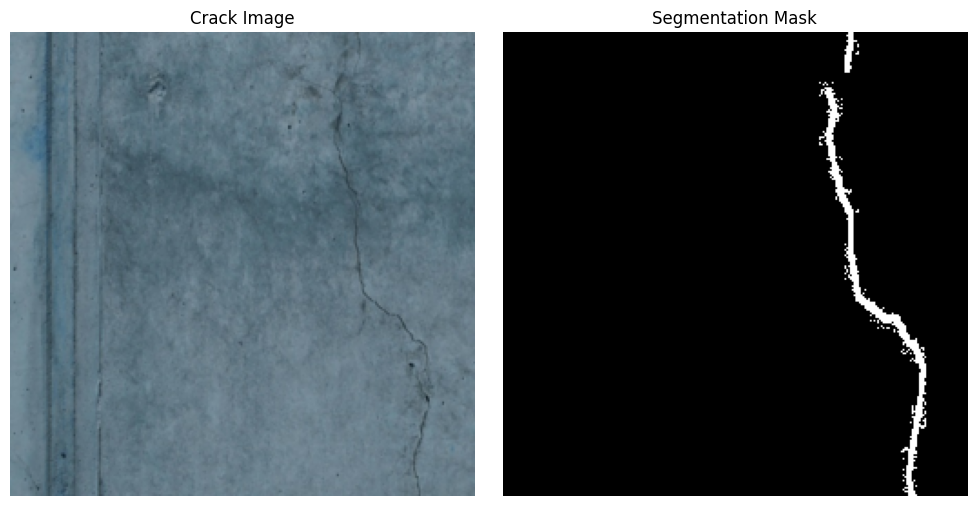

In [ ]:
import random

# Choose a random index from the training dataset
random_index = random.randint(0, len(train_ds) - 1)

# Get image and mask pair
image, mask = train_ds[random_index]

# Convert image tensor to NumPy for plotting
image_np = image.permute(1, 2, 0).numpy()  # CHW → HWC
mask_np = mask.squeeze().numpy()           # 1xHxW → HxW

# Plot the image and mask side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Crack Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_np, cmap='gray')
plt.title("Segmentation Mask")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Use Segmentation Models PyTorch (SMP) to load U-Net with pretrained VGG-16
model = smp.Unet(
    encoder_name="vgg16",        # VGG-16 as encoder
    encoder_weights="imagenet",  # Pretrained on ImageNet
    in_channels=3,               # RGB input
    classes=1,                   # Binary segmentation
    activation=None              # We'll apply sigmoid later manually
).cuda()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/553M [00:00<?, ?B/s]

In [ ]:
class BC_Loss(nn.Module):
    def __init__(self, alpha=0.5, gamma=0.5, eps=1e-7):
        super(BC_Loss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.bce = nn.BCEWithLogitsLoss(reduction='none')  # Weighted later

    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)  # convert logits to probabilities

        # Approximate Boundary Loss (simple pixel-wise difference)
        boundary_loss = torch.abs(preds - targets).mean()

        # Dice Loss
        intersection = (preds * targets).sum()
        dice_loss = 1 - (2. * intersection + self.eps) / (preds.sum() + targets.sum() + self.eps)

        # Weighted Cross Entropy
        wce = self.bce(preds, targets)
        weights = 1 + 5 * (targets == 1).float()  # Give more weight to crack pixels
        wce_loss = (wce * weights).mean()

        # Combo Loss
        combo_loss = (1 - self.gamma) * dice_loss + self.gamma * wce_loss
        return self.alpha * boundary_loss + (1 - self.alpha) * combo_loss


In [ ]:
# Define loss function and optimizer
loss_fn = BC_Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 📉 Track training and validation loss
train_losses = []
val_losses = []

# Training and Validation Functions (unchanged)
def train_epoch(loader):
    model.train()
    total_loss = 0
    for images, masks in loader:
        images, masks = images.cuda(), masks.cuda()
        preds = model(images)
        loss = loss_fn(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate_epoch(loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.cuda(), masks.cuda()
            preds = model(images)
            loss = loss_fn(preds, masks)
            total_loss += loss.item()
    return total_loss / len(loader)

# 🧠 Training Loop
epochs = 25  # Set your desired number of epochs
for epoch in range(epochs):
    train_loss = train_epoch(train_loader)
    val_loss = validate_epoch(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"📆 Epoch {epoch+1}/{epochs} — Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


📆 Epoch 1/25 — Train Loss: 0.3297, Val Loss: 0.2906
📆 Epoch 2/25 — Train Loss: 0.2793, Val Loss: 0.2811
📆 Epoch 3/25 — Train Loss: 0.2747, Val Loss: 0.2952
📆 Epoch 4/25 — Train Loss: 0.2717, Val Loss: 0.2781
📆 Epoch 5/25 — Train Loss: 0.2690, Val Loss: 0.2780
📆 Epoch 6/25 — Train Loss: 0.2674, Val Loss: 0.2719
📆 Epoch 7/25 — Train Loss: 0.2651, Val Loss: 0.2689
📆 Epoch 8/25 — Train Loss: 0.2629, Val Loss: 0.2687
📆 Epoch 9/25 — Train Loss: 0.2619, Val Loss: 0.2689
📆 Epoch 10/25 — Train Loss: 0.2618, Val Loss: 0.2693
📆 Epoch 11/25 — Train Loss: 0.2587, Val Loss: 0.2688
📆 Epoch 12/25 — Train Loss: 0.2572, Val Loss: 0.2725
📆 Epoch 13/25 — Train Loss: 0.2560, Val Loss: 0.2665
📆 Epoch 14/25 — Train Loss: 0.2553, Val Loss: 0.2681
📆 Epoch 15/25 — Train Loss: 0.2541, Val Loss: 0.2659
📆 Epoch 16/25 — Train Loss: 0.2528, Val Loss: 0.2648
📆 Epoch 17/25 — Train Loss: 0.2514, Val Loss: 0.2645
📆 Epoch 18/25 — Train Loss: 0.2497, Val Loss: 0.2637
📆 Epoch 19/25 — Train Loss: 0.2493, Val Loss: 0.2678
📆 

Splitting test, train and validation dataset

In [ ]:
# ✅ Define the test dataset and loader
test_ds = CrackDataset(test_imgs, test_masks, transform)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)


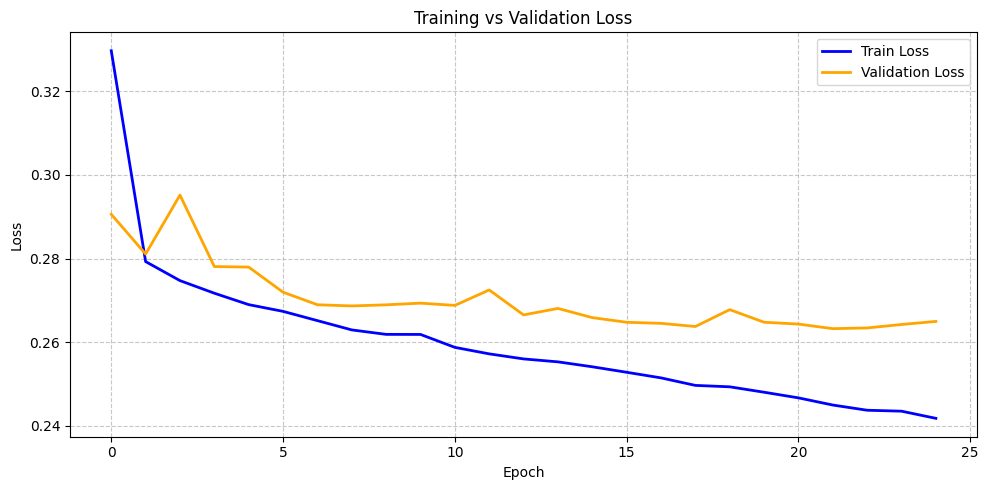


📊 Test Set Metrics:
IoU (Jaccard):  0.5002
Precision:      0.6430
Recall:         0.6220
F1 Score:       0.6184


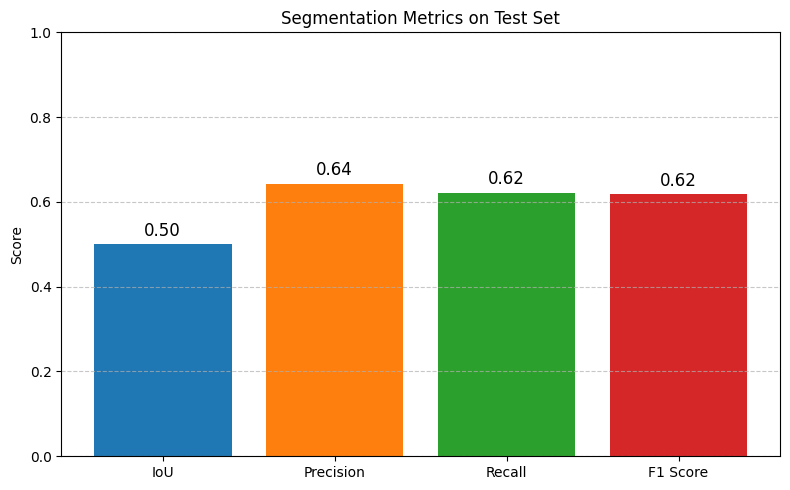

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import numpy as np

# -----------------------------------------------------------------------------------
# 📈 Plot Training and Validation Loss
# -----------------------------------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------------
# 📊 Compute Segmentation Metrics on Test Set
# -----------------------------------------------------------------------------------
def evaluate_metrics(model, dataloader, threshold=0.5):
    model.eval()
    iou_list, precision_list, recall_list, f1_list = [], [], [], []

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.cuda()
            masks = masks.cuda()

            preds = model(images)
            preds = torch.sigmoid(preds)
            preds = (preds > threshold).float()

            preds_flat = preds.view(-1).cpu().numpy()
            masks_flat = masks.view(-1).cpu().numpy()

            iou = jaccard_score(masks_flat, preds_flat, zero_division=0)
            precision = precision_score(masks_flat, preds_flat, zero_division=0)
            recall = recall_score(masks_flat, preds_flat, zero_division=0)
            f1 = f1_score(masks_flat, preds_flat, zero_division=0)

            iou_list.append(iou)
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)

    avg_iou = np.mean(iou_list)
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_f1 = np.mean(f1_list)

    print("\n📊 Test Set Metrics:")
    print(f"IoU (Jaccard):  {avg_iou:.4f}")
    print(f"Precision:      {avg_precision:.4f}")
    print(f"Recall:         {avg_recall:.4f}")
    print(f"F1 Score:       {avg_f1:.4f}")

    return avg_iou, avg_precision, avg_recall, avg_f1

# 🔍 Run Evaluation on Test Set
avg_iou, avg_precision, avg_recall, avg_f1 = evaluate_metrics(model, test_loader)

# -----------------------------------------------------------------------------------
# 📈 Plot Segmentation Metrics as a Bar Chart
# -----------------------------------------------------------------------------------
metrics = [avg_iou, avg_precision, avg_recall, avg_f1]
labels = ['IoU', 'Precision', 'Recall', 'F1 Score']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, metrics, color=colors)
plt.ylim(0, 1)
plt.title("Segmentation Metrics on Test Set")
plt.ylabel("Score")

# Annotate values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height + 0.02, f'{height:.2f}', ha='center', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


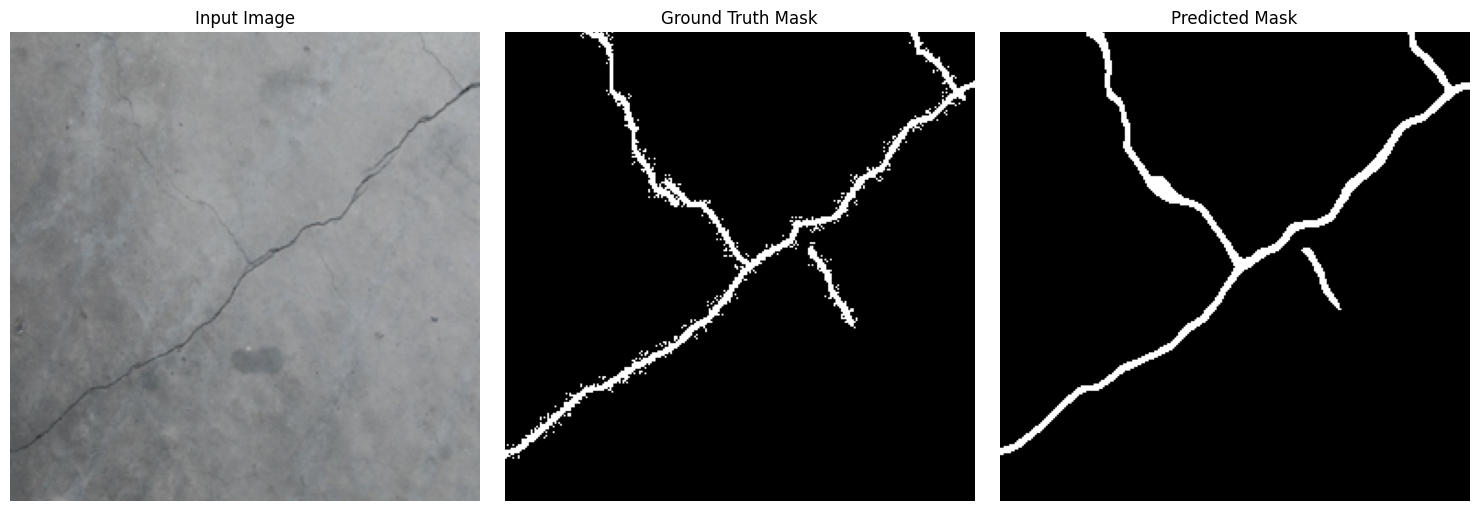

In [ ]:
# 🧪 Visualize predictions from test set
test_ds = CrackDataset(test_imgs, test_masks, transform)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True)

def visualize_test_prediction(index=0):
    model.eval()
    image, mask = test_ds[index]
    with torch.no_grad():
        pred = torch.sigmoid(model(image.unsqueeze(0).cuda()))[0][0].cpu().numpy()

    image_np = image.permute(1, 2, 0).numpy()
    mask_np = mask.squeeze().numpy()

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask_np, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred > 0.5, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# 👇 Try different indices
visualize_test_prediction(index=3)


In [ ]:
# 📤 Upload your own image to segment
from google.colab import files
uploaded = files.upload()


Saving sample 2.jpg to sample 2.jpg


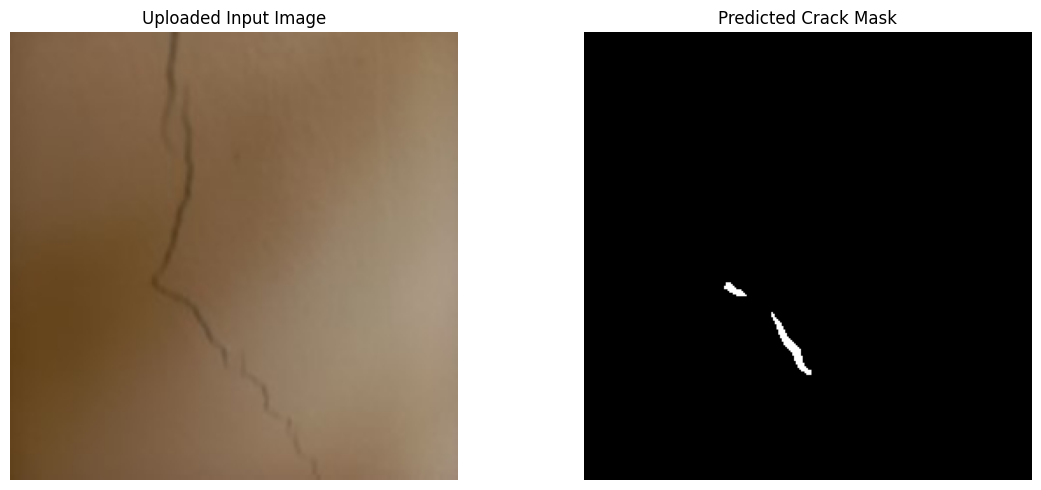

In [ ]:
# 🖼️ Predict crack segmentation on uploaded image
from PIL import Image

uploaded_path = list(uploaded.keys())[0]
model.eval()

# Load and preprocess image
input_image = Image.open(uploaded_path).convert('RGB').resize((256, 256))
input_tensor = transform(input_image).unsqueeze(0).cuda()

# Predict
with torch.no_grad():
    prediction = torch.sigmoid(model(input_tensor))[0][0].cpu().numpy()

# Plot result
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title("Uploaded Input Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(prediction > 0.5, cmap='gray')
plt.title("Predicted Crack Mask")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Define path to save the model inside your Colab Notebooks folder on Drive
model_save_path = "/content/drive/MyDrive/Colab Notebooks/crack_segmentation_model_U-net_2.pth"

# Save the model
torch.save(model.state_dict(), model_save_path)

print(f"✅ Model saved at: {model_save_path}")


✅ Model saved at: /content/drive/MyDrive/Colab Notebooks/crack_segmentation_model_U-net_2.pth
